<a href="https://colab.research.google.com/github/hamednasr/transformers/blob/main/Encoder_Decoder_transformers_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Encoder-Decoder Seq2Seq Transformer

In [ ]:
!pip -q install transformers datasets sentencepiece sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 58.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from datasets import load_dataset
from datetime import datetime
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-112-f999251d1fe0>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_v, d_model, n_heads, max_len, causal = False):
    super().__init__()

    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads

    self.W_q = nn.Linear(d_model,d_k*n_heads)
    self.W_k = nn.Linear(d_model,d_k*n_heads)
    self.W_v = nn.Linear(d_model,d_v*n_heads)
    self.fc = nn.Linear(d_v*n_heads, d_model)

    self.causal = causal

    if causal:
      cm = torch.tril(torch.ones(max_len,max_len))
      self.register_buffer('causal_mask', cm.view(1,1,max_len,max_len))


  def forward(self, q, k, v, pad_mask=None):
    Q = self.W_q(q)  # N × T × h*d_k
    K = self.W_k(k)  # N × T × h*d_k
    V = self.W_v(v)  # N × T × h*d_v

    N = Q.shape[0]
    T_output = Q.shape[1] # Q comes from decoder and K,V come from encoder
    T_input = K.shape[1]  # it also works for encoder-decoder transformers

    Q = Q.view(N, T_output, self.n_heads, self.d_k).transpose(1,2) # N × T × h*d_k -->> N × h × T × d_k
    K = K.view(N, T_input, self.n_heads, self.d_k).transpose(1,2) # N × T × h*d_k -->> N × h × T × d_k
    V = V.view(N, T_input, self.n_heads, self.d_k).transpose(1,2) # N × T × h*d_k -->> N × h × T × d_k

    AttentionScores = Q @ K.transpose(2,3) / np.sqrt(self.d_k) #  N × h × T × T

    if pad_mask is not None:
      AttentionScores = AttentionScores.masked_fill(pad_mask[:,None,None,:] == 0, float('-inf'))

    if self.causal:
      AttentionScores = AttentionScores.masked_fill(self.causal_mask[:,:,:T_output,:T_input] == 0, float('-inf'))


    AttentionWeights = F.softmax(AttentionScores, dim=-1) #  N × h × T × T

    A = AttentionWeights @ V #  N × h × T × d_v
    A = A.transpose(1,2).contiguous().view(N, T_output, self.n_heads*self.d_v ) #  N × T × h*d_v

    return self.fc(A)


In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, d_k, d_v, d_model, n_heads, max_len, dropout_prob=0.2):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.mha = MultiHeadAttention(d_k, d_v, d_model, n_heads,max_len,causal=False)
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model*3),
        nn.GELU(),
        nn.Linear(d_model*3, d_model),
        nn.Dropout(dropout_prob)
    )
    self.dropout = nn.Dropout(dropout_prob)

  def forward(self, x, pad_mask= None):
    x = self.ln1(x + self.mha(x,x,x,pad_mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)

    return x

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, d_k, d_v, d_model, n_heads, max_len, dropout_prob=0.2):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.ln3 = nn.LayerNorm(d_model)

    self.mha1 = MultiHeadAttention(d_k, d_v, d_model, n_heads, max_len, causal=True)
    self.mha2 = MultiHeadAttention(d_k, d_v, d_model, n_heads, max_len, causal=False)

    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model*3),
        nn.GELU(),
        nn.Linear(d_model*3, d_model),
        nn.Dropout(dropout_prob)
    )
    self.dropout = nn.Dropout(dropout_prob)

  def forward(self, encoder_output, decoder_input, enc_mask=None, dec_mask=None):
    x = self.ln1(decoder_input + self.mha1(decoder_input, decoder_input, decoder_input, dec_mask)) # first multihead attention
    x = self.ln2(x + self.mha2(x, encoder_output, encoder_output, enc_mask)) # second multihead attention
    x = self.ln3(x + self.ann(x))
    x = self.dropout(x)

    return x

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len = 2048, dropout_prob=0.2):
    super().__init__()
    self.dropout = nn.Dropout(dropout_prob)

    position = torch.arange(max_len).unsqueeze(1)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term * (-np.log(10000.0) / d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position * div_term)
    pe[0, :, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe',pe)

  def forward(self, x):
    x = x+self.pe[:, :x.size(1), :]

    return self.dropout(x)

In [ ]:
class Encoder(nn.Module):

  def __init__(self, vocab_size, max_len,d_model,d_k,d_v,
               n_heads,n_layers,dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size,d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [EncoderBlock(d_k, d_v,
                                        d_model,
                                        n_heads,
                                        max_len,
                                        dropout_prob) for i in range(n_layers)]

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    # self.fc = nn.Linear(d_model, n_classes)

  def forward(self, x, pad_mask=None):
    x = self.embedding(x)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(x, pad_mask)

    # x = x[:,0,:] #many to one: get one of the hidden vectors if it is a one-classfification problem
    x = self.ln(x)
    # x = self.fc(x)  # no need for this in encoder-decoder

    return x


In [ ]:
class Decoder(nn.Module):

  def __init__(self, vocab_size, max_len,d_model,d_k,d_v,
               n_heads,n_layers,dropout_prob):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size,d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    transformer_blocks = [DecoderBlock(d_k, d_v,
                                        d_model,
                                        n_heads,
                                        max_len,
                                        dropout_prob) for i in range(n_layers)]

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    self.fc = nn.Linear(d_model, vocab_size)

  def forward(self, encoder_output, decoder_input, enc_mask=None, dec_mask=None):
    x = self.embedding(decoder_input)
    x = self.pos_encoding(x)

    for block in self.transformer_blocks:
      x = block(encoder_output, x, enc_mask, dec_mask)


    # x = x[:,0,:] #many to one: get one of the hidden vectors if it is a one-classfification problem


    x = self.ln(x)
    x = self.fc(x) # many to many since output of model is a text

    return x


In [ ]:
class Transformer(nn.Module):

  def __init__(self, encoder, decoder):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, encoder_input, decoder_input, enc_mask, dec_mask):
    encoder_output = self.encoder(encoder_input, enc_mask)
    decoder_output = self.decoder(encoder_output, decoder_input, enc_mask, dec_mask)

    return decoder_output


## dummy data and transformer sanity check

In [ ]:
encoder = Encoder(vocab_size=10000,
                  max_len=512,
                  d_model=64,
                  d_k=8,
                  d_v=8,
                  n_heads=6,
                  n_layers=3,
                  dropout_prob=0.1)

decoder = Decoder(vocab_size=20000,
                  max_len=512,
                  d_model=64,
                  d_k=8,
                  d_v=8,
                  n_heads=6,
                  n_layers=3,
                  dropout_prob=0.1)

transformer = Transformer(encoder, decoder)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
encoder = encoder.to(device)
decoder = decoder.to(device)

cuda:0


In [ ]:
enc_inp = np.random.randint(0,10000, size=(5,512))
enc_inp = torch.tensor(enc_inp).to(device)

dec_inp = np.random.randint(0,20000, size=(5,512))
dec_inp = torch.tensor(enc_inp).to(device)

maske = np.ones((5,512))
maske[:,256:]= 0
maske = torch.tensor(maske).to(device)

maskd = np.ones((5,512))
maskd[:,128:]= 0
maskd = torch.tensor(maskd).to(device)

<ipython-input-12-5bd86d4e496c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dec_inp = torch.tensor(enc_inp).to(device)


In [ ]:
output = transformer(enc_inp, dec_inp, maske, maskd)
output.shape

torch.Size([5, 512, 20000])

## download datasaet (english-spanish) convert to csv

In [ ]:
!wget https://lazyprogrammer.me/course_files/nlp3/spa.txt

--2023-10-27 09:18:01--  https://lazyprogrammer.me/course_files/nlp3/spa.txt
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘spa.txt’

spa.txt                 [         <=>        ]   7.45M  2.65MB/s    in 2.8s    

2023-10-27 09:18:05 (2.65 MB/s) - ‘spa.txt’ saved [7817148]



In [ ]:
df = pd.read_csv('spa.txt',sep='\t',header=None)
df

,0,1
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Hi.,Hola.
4,Run!,¡Corre!
...,...,...
115240,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
115241,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
115242,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...
115243,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe..."


In [ ]:
df = df.iloc[:40000,:]
df.columns = ['en','es']
df.to_csv('spa.csv', index=None)

In [ ]:
raw_dataset = load_dataset('csv', data_files='spa.csv')
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 115245
    })
})

In [ ]:
split = raw_dataset['train'].train_test_split(test_size=0.05, seed=5)
split

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 109482
    })
    test: Dataset({
        features: ['en', 'es'],
        num_rows: 5763
    })
})

## tokenization

In [ ]:
checkpoint = 'Helsinki-NLP/opus-mt-en-es'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
split['train']['en'][0], tokenizer(split['train']['en'][0])

('Did you go to office yesterday?',
 {'input_ids': [2837, 40, 290, 13, 1908, 9023, 21, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]})

In [ ]:
split['train']['es'][0], tokenizer(text_target=split['train']['es'][0])

('¿Fuiste ayer a la oficina?',
 {'input_ids': [50, 37535, 8858, 8, 6, 3095, 21, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]})

In [ ]:
target = tokenizer(text_target=split['train']['es'][0])

In [ ]:
tokenizer.convert_ids_to_tokens(target['input_ids'])

['▁¿', 'Fuiste', '▁ayer', '▁a', '▁la', '▁oficina', '?', '</s>']

## map tokenizer function to all data , preprocess data

In [ ]:
max_input_length=256
max_target_length=256

In [ ]:
def preprocess_fn(batch):
  model_inputs = tokenizer(batch['en'], max_length=max_input_length, truncation=True)
  labels = tokenizer(text_target=batch['en'], max_length=max_target_length, truncation=True)
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [ ]:
tokenized_dataset = split.map(preprocess_fn,
                              batched=True,
                              remove_columns=split['train'].column_names)
tokenized_dataset

Map:   0%|          | 0/109482 [00:00<?, ? examples/s]

Map:   0%|          | 0/5763 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 109482
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5763
    })
})

In [ ]:
tokenized_dataset['train'][0]

{'input_ids': [2837, 40, 290, 13, 1908, 9023, 21, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [1549, 96, 11, 4932, 290, 13, 25, 29288, 11, 98, 1304, 3836, 21, 0]}

## data collator

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)
data_collator

DataCollatorForSeq2Seq(tokenizer=MarianTokenizer(name_or_path='Helsinki-NLP/opus-mt-en-es', vocab_size=65001, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	65000: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, model=None, padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

In [ ]:
data_collator([tokenized_dataset['train'][i] for i in range(6,11)])
#end of sentence token is 0 and
# input padding is 65000 and target padding is -100

{'input_ids': tensor([[  552,  2275,     5, 15045,    16,     5,  9125,    62,    16,     5,
          6332,     3,     0],
        [ 5266,    10,  4963,  1938,    35,     8,  1684,     3,     0, 65000,
         65000, 65000, 65000],
        [ 5266,  6321,   310,  3205,    73,  1237,     3,     0, 65000, 65000,
         65000, 65000, 65000],
        [ 5266,  2539,    35,     5,   114,  1658,     7, 15980,     3,     0,
         65000, 65000, 65000],
        [   33,    20,    92,    35,   125,   327,     3,     0, 65000, 65000,
         65000, 65000, 65000]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]), 'labels': tensor([[  552, 47536,  3963,     5, 15045,    16,     5,     8,   698,  1304,
           346,   288,    62,    16,     5,   129,  1852,    93,     3,     0],


## special tokens

In [ ]:
tokenizer.all_special_ids, tokenizer.all_special_tokens

([0, 1, 65000], ['</s>', '<unk>', '<pad>'])

In [ ]:
tokenizer('<unk>') #end of sentence is always added (</s>)

{'input_ids': [1, 0], 'attention_mask': [1, 1]}

In [ ]:
# this tokenizer does not have start of sentence tokenizer, which is required for decoder part
tokenizer.add_special_tokens({'cls_token':'<s>'})

1

In [ ]:
tokenizer('<s>')

{'input_ids': [65001, 0], 'attention_mask': [1, 1]}

In [ ]:
tokenizer.all_special_ids, tokenizer.all_special_tokens

([0, 1, 65000, 65001], ['</s>', '<unk>', '<pad>', '<s>'])

In [ ]:
tokenizer.vocab_size # it is actually 65002 , we added <s>

65001

In [ ]:
tokenizer.pad_token_id

65000

## data loader

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(tokenized_dataset['train'],
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=data_collator)

val_loader = DataLoader(tokenized_dataset['test'],
                          batch_size=BATCH_SIZE,
                          collate_fn=data_collator)

In [ ]:
train_loader

In [ ]:
for batch in train_loader:
  for k, v in batch.items():
    print('k:',k,'v.shape:',v.shape)
  break

k: input_ids v.shape: torch.Size([32, 15])
k: attention_mask v.shape: torch.Size([32, 15])
k: labels v.shape: torch.Size([32, 26])


In [ ]:
for batch in train_loader:
  targets = batch['labels'][:3,:]
  print(targets)
  print('************************************************')
  print(torch.roll(targets,shifts=1,dims=1)) # decoder input
  break

tensor([[   33,    87,   243,     8,    25, 33064,    61,    16,   125,   376,
          2993,     3,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100],
        [   99,    25, 10768,    16,   125,    95,  2553,     3,     0,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100],
        [   33,    20,   210,  1266,    11,  4932,     5,    25, 15501,     3,
             0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100]])
************************************************
tensor([[ -100,    33,    87,   243,     8,    25, 33064,    61,    16,   125,
           376,  2993,     3,     0,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100, 

In [ ]:
tokenizer.max_model_input_sizes

{'Helsinki-NLP/opus-mt-en-de': 512}

## create model

In [ ]:
encoder = Encoder(vocab_size=65002,
                  max_len=512,
                  d_model=32,
                  d_k=8,
                  d_v=8,
                  n_heads=6,
                  n_layers=3,
                  dropout_prob=0.1)

decoder = Decoder(vocab_size=65002,
                  max_len=512,
                  d_model=32,
                  d_k=8,
                  d_v=8,
                  n_heads=6,
                  n_layers=3,
                  dropout_prob=0.1)

transformer = Transformer(encoder, decoder)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
encoder.to(device)
decoder.to(device)

cuda:0


Decoder(
  (embedding): Embedding(65002, 32)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): DecoderBlock(
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ln3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mha1): MultiHeadAttention(
        (W_q): Linear(in_features=32, out_features=48, bias=True)
        (W_k): Linear(in_features=32, out_features=48, bias=True)
        (W_v): Linear(in_features=32, out_features=48, bias=True)
        (fc): Linear(in_features=48, out_features=32, bias=True)
      )
      (mha2): MultiHeadAttention(
        (W_q): Linear(in_features=32, out_features=48, bias=True)
        (W_k): Linear(in_features=32, out_features=48, bias=True)
        (W_v): Linear(in_features=32, out_features=48, bias=True)
        (fc): Linear(in_features=48, out_features=32, bias=True)
      )
 

In [ ]:
train_loader

## train model

In [ ]:
def TrainModel(model, train_loader, val_loader, epochs):

  trainLoss = []
  testLoss  = []

  lossfun = nn.CrossEntropyLoss(ignore_index=-100)
  optimizer = torch.optim.Adam(model.parameters())


  for epoch in range(epochs):
    model.train()
    t0 = datetime.now()
    trainBatchLoss = []

    for batch in train_loader:
      batch = {k:v.to(device) for k,v in batch.items()}

      encoder_input = batch['input_ids']
      encoder_mask = batch['attention_mask']
      targets = batch['labels']

      decoder_input = targets.clone().detach()
      decoder_input = torch.roll(decoder_input, shifts=1, dims=1)
      decoder_input[:,0] = 65001

      #-100 is not valid for transformers, change to positive value
      decoder_input = decoder_input.masked_fill(decoder_input == -100,tokenizer.pad_token_id)

      decoder_mask = torch.ones_like(decoder_input)
      decoder_mask = decoder_mask.masked_fill(decoder_input == tokenizer.pad_token_id,0)


      model_output = model(encoder_input,decoder_input,encoder_mask,decoder_mask)
      # print(model_output.shape)
      loss = lossfun(model_output.transpose(2,1), targets)


      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      trainBatchLoss.append(loss.item())

    trainLoss.append(np.mean(trainBatchLoss))


    model.eval()
    testBatchLoss = []

    for batch in val_loader:
      batch = {k:v.to(device) for k,v in batch.items()}

      encoder_input = batch['input_ids']
      encoder_mask = batch['attention_mask']
      targets = batch['labels']

      #decoder input is shifted targets
      decoder_input = targets.clone().detach()
      decoder_input = torch.roll(decoder_input, shifts=1, dims=1)
      decoder_input[:,0] = 65001

      #-100 is not valid for transformers, change to positive value
      decoder_input = decoder_input.masked_fill(decoder_input == -100,tokenizer.pad_token_id)

      decoder_mask = torch.ones_like(decoder_input)
      decoder_mask = decoder_mask.masked_fill(decoder_input == tokenizer.pad_token_id,0)


      model_output = model(encoder_input,decoder_input,encoder_mask,decoder_mask)
      # print(model_output.shape)
      loss = lossfun(model_output.transpose(2,1), targets)


      testBatchLoss.append(loss.item())

    # get loss and error rate from the test batch

    testLoss.append(np.mean(testBatchLoss))


    t = datetime.now() - t0

    print(f'Epoch: {epoch}/{epochs},  \
    Train Loss: {trainLoss[epoch].item():.4f},  \
    Test Loss: {testLoss[epoch].item():.4f},  Duration:{t:.2f}')


  return trainLoss,testLoss,model

In [ ]:
trainLoss,testLoss,model = TrainModel(transformer,train_loader,val_loader,epochs=7)

Epoch: 0/7,            Train Loss: 2.3052,            Test Loss: 1.5858, Duration:0:04:17.624676
Epoch: 1/7,            Train Loss: 1.9932,            Test Loss: 1.3127, Duration:0:04:17.218155
Epoch: 2/7,            Train Loss: 1.7756,            Test Loss: 1.1207, Duration:0:04:17.324995
Epoch: 3/7,            Train Loss: 1.6147,            Test Loss: 0.9886, Duration:0:04:15.512742
Epoch: 4/7,            Train Loss: 1.4806,            Test Loss: 0.8678, Duration:0:04:16.315756
Epoch: 5/7,            Train Loss: 1.3744,            Test Loss: 0.7871, Duration:0:04:14.734954
Epoch: 6/7,            Train Loss: 1.2862,            Test Loss: 0.7199, Duration:0:04:14.960126


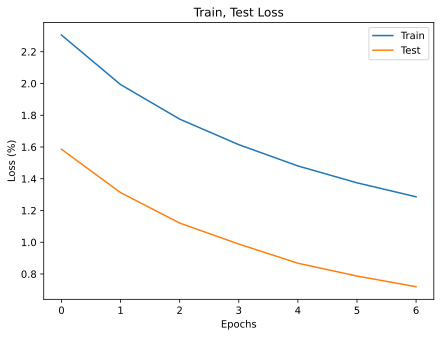

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))

ax.plot(trainLoss,label='Train')
ax.plot(testLoss,label='Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (%)')
ax.set_title(f'Train, Test Loss')
ax.legend()

plt.show()

### test the model

In [ ]:
sentence = split['test']['en'][12]
sentence

'We have to notify the police.'

In [ ]:
encoder_input = tokenizer(sentence, return_tensors = 'pt')
encoder_input.to(device)
encoder_input

{'input_ids': tensor([[  124,    65,    13, 14347,     5,  1351,     3,     0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
#using decoder in generative mode,decoder input is just a sentence start tag
#ignore final 0 </s>
decoder_input = tokenizer(text_target= '<s>' ,return_tensors = 'pt')
decoder_input.to(device)
decoder_input

{'input_ids': tensor([[65001,     0]], device='cuda:0'), 'attention_mask': tensor([[1, 1]], device='cuda:0')}

In [ ]:
output = transformer(encoder_input['input_ids'],
                     decoder_input['input_ids'][:,:-1],
                     encoder_input['attention_mask'],
                     decoder_input['attention_mask'][:,:-1]) #?

output , output.shape

(tensor([[[ 6.0370, -7.5077,  2.9217,  ..., -7.3526, -8.6367, -7.7505]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 torch.Size([1, 1, 65002]))